In [2]:
from omegaconf import OmegaConf
import os, sys

#Add LaTex to PATH
os.environ["PATH"] += os.pathsep + "/global/common/software/nersc/pm-2023q2/sw/texlive/2022/bin/x86_64-linux"

import torch
import glob
import pickle
import pandas as pd
import numpy as np
from scipy.stats import norm as scipy_norm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pytorch_lightning import Trainer
import time
import scienceplots
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from models import CuboidTransformerModel
from models.lightning import SEVIRPLModule

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
model_name="earthformer_edl_1_drop_0_pretrain"
save_dir = "../models/experiments/{}/".format(model_name)
oc_file = os.path.join(save_dir, "cfg.yaml")
checkpoints = os.path.join(save_dir, "checkpoints/")
oc_from_file = OmegaConf.load(open(oc_file, "r"))

In [5]:
dataset_oc = OmegaConf.to_object(oc_from_file.dataset)
micro_batch_size=1
dm = SEVIRPLModule.get_sevir_datamodule(
        dataset_oc=dataset_oc,
        micro_batch_size=micro_batch_size,
        num_workers=8,)
dm.prepare_data()
dm.setup()

In [6]:
ckpts = glob.glob(checkpoints + '*.ckpt')
ckpts.sort()
print(ckpts)
curr_ckpt = ckpts[-1]
print(curr_ckpt)

['../models/experiments/earthformer_edl_1_drop_0_pretrain/checkpoints/last.ckpt', '../models/experiments/earthformer_edl_1_drop_0_pretrain/checkpoints/model-epoch=003.ckpt']
../models/experiments/earthformer_edl_1_drop_0_pretrain/checkpoints/model-epoch=003.ckpt


In [7]:
total_num_steps = SEVIRPLModule.get_total_num_steps(
    epoch=oc_from_file.optim.max_epochs,
    num_samples=dm.num_train_samples,
    total_batch_size=oc_from_file.optim.total_batch_size,
)
pl_module = SEVIRPLModule.load_from_checkpoint(curr_ckpt, total_num_steps=total_num_steps, save_dir=model_name, oc_file=oc_file)
pl_module.eval()
model = pl_module.torch_nn_module.to(device)

/pscratch/sd/a/akhot/earth/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [8]:
test_loader = dm.test_dataloader()

In [55]:
inference_time = []

pl_module.test_mae.reset()
pl_module.test_mse.reset()
pl_module.test_score.reset()

for batch_idx, batch in enumerate(test_loader):
    data_seq = batch['vil'].contiguous()
    x = data_seq[pl_module.in_slice].to(device)
    y = data_seq[pl_module.out_slice].to(device)
    micro_batch_size = x.shape[pl_module.layout.find("N")]
    data_idx = int(batch_idx * micro_batch_size)
    
    start_time = time.time()
    output = model(x)
    gamma, v, alpha, beta = torch.split(output, 1, -1)
    aleatoric = beta/(alpha - 1)
    epistemic = aleatoric/v
    inference_time.append(time.time() - start_time)
    
    step_mse = pl_module.test_mse(gamma, y)
    step_mae = pl_module.test_mae(gamma, y)
    pl_module.test_score.update(gamma, y)
    
print('MSE: ', pl_module.test_mse.compute().cpu().numpy())
print('MAE: ', pl_module.test_mae.compute().cpu().numpy())
test_score = pl_module.test_score.compute()
print(test_score)
print('Inference time: ', np.mean(inference_time))

MSE:  0.005757323
MAE:  0.03694504
{16: {'csi': 0.6894003748893738, 'pod': 0.8929781317710876, 'sucr': 0.751491129398346, 'bias': 2.938887596130371}, 74: {'csi': 0.5902105569839478, 'pod': 0.7049483060836792, 'sucr': 0.7838423252105713, 'bias': 1.6834732294082642}, 133: {'csi': 0.19099541008472443, 'pod': 0.22713340818881989, 'sucr': 0.5455451011657715, 'bias': 0.3607860803604126}, 160: {'csi': 0.003343078074976802, 'pod': 0.003366640768945217, 'sucr': 0.32325243949890137, 'bias': 0.00022576627088710666}, 181: {'csi': 1.2956894579474465e-06, 'pod': 1.2957040098626749e-06, 'sucr': 0.10334926843643188, 'bias': 3.271491411105387e-10}, 219: {'csi': 0.0, 'pod': 0.0, 'sucr': 0.0, 'bias': 0.0}, 'avg': {'csi': 0.24565845262041344, 'pod': 0.30473796375275697, 'sucr': 0.41791337728500366, 'bias': 0.8305621120828474}}
Inference time:  0.01201755799140494


In [9]:
import sys
sys.path.append('../') # add sevir module to path
from utils.visualization.sevir_cmap import get_cmap, VIL_COLORS, VIL_LEVELS
from matplotlib.patches import Patch

plt.style.use('science')

# Get colormaps for encoded types
cmap_dict = lambda s: {'cmap': get_cmap(s, encoded=True)[0],
                           'norm': get_cmap(s, encoded=True)[1],
                           'vmin': get_cmap(s, encoded=True)[2],
                           'vmax': get_cmap(s, encoded=True)[3]}

In [10]:
def generate_image(target, output, mse, unc, save_path):
    
    minutes = [10, 20, 30, 40]
    frames = []
    fig,axs = plt.subplots(4,4,figsize=(22,15))

    for i in range(4):
        for j in range(4):
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].set_xticklabels([])
            axs[i, j].set_yticklabels([])

    _mse_min, _mse_max = np.min(mse), np.max(mse)
    _unc_min, _unc_max = np.min(unc), np.max(unc)

    axs[0, 0].set_ylabel("Target", fontsize=24, rotation=0, labelpad=40)
    axs[1, 0].set_ylabel("Prediction", fontsize=24, rotation=0, labelpad=60)
    axs[2, 0].set_ylabel("Error", fontsize=24, rotation=0, labelpad=40)
    axs[3, 0].set_ylabel("Uncertainty", fontsize=24, rotation=0, labelpad=70)

    for idx, i in enumerate(minutes):
        frame_idx = int(i / 5 - 2)

        axs[0, idx].set_title("{} Minutes".format(str(i)), fontsize=24)

        f0 = axs[0, idx].imshow(target[0, frame_idx, :, :, 0],**cmap_dict('vil'))
        # axs[idx, 0].set_title('Target', fontsize=24)
        f1 = axs[1, idx].imshow(output[0, frame_idx, :, :, 0],**cmap_dict('vil'))
        # axs[idx, 1].set_title('Output', fontsize=24)
        f2 = axs[2, idx].imshow(mse[0, frame_idx, :, :, 0], vmin=_mse_min, vmax=_mse_max)
        # axs[idx, 2].set_title('RMSE', fontsize=24)

        # cbar = fig.colorbar(f2, ax=axs[idx, 2], orientation='vertical')

        f3 = axs[3, idx].imshow(unc[0, frame_idx, :, :, 0], vmin=_unc_min, vmax=_unc_max)
        # axs[idx, 3].set_title('Uncertainty', fontsize=24)

        # cbar = fig.colorbar(f3, ax=axs[idx, 3], orientation='vertical')


    # Legend of thresholds
    num_thresh_legend = len(VIL_LEVELS) - 1
    legend_elements = [Patch(facecolor=VIL_COLORS[i],
                             label=f'{int(VIL_LEVELS[i - 1])}-{int(VIL_LEVELS[i])}')
                       for i in range(1, num_thresh_legend + 1)]
    x_legend = -1.5
    axs[0][0].legend(handles=legend_elements, loc='center left',
                    bbox_to_anchor=(x_legend, -0.),
                    borderaxespad=0, frameon=False, fontsize='20')

    plt.savefig(save_path, dpi=300)
    plt.show()

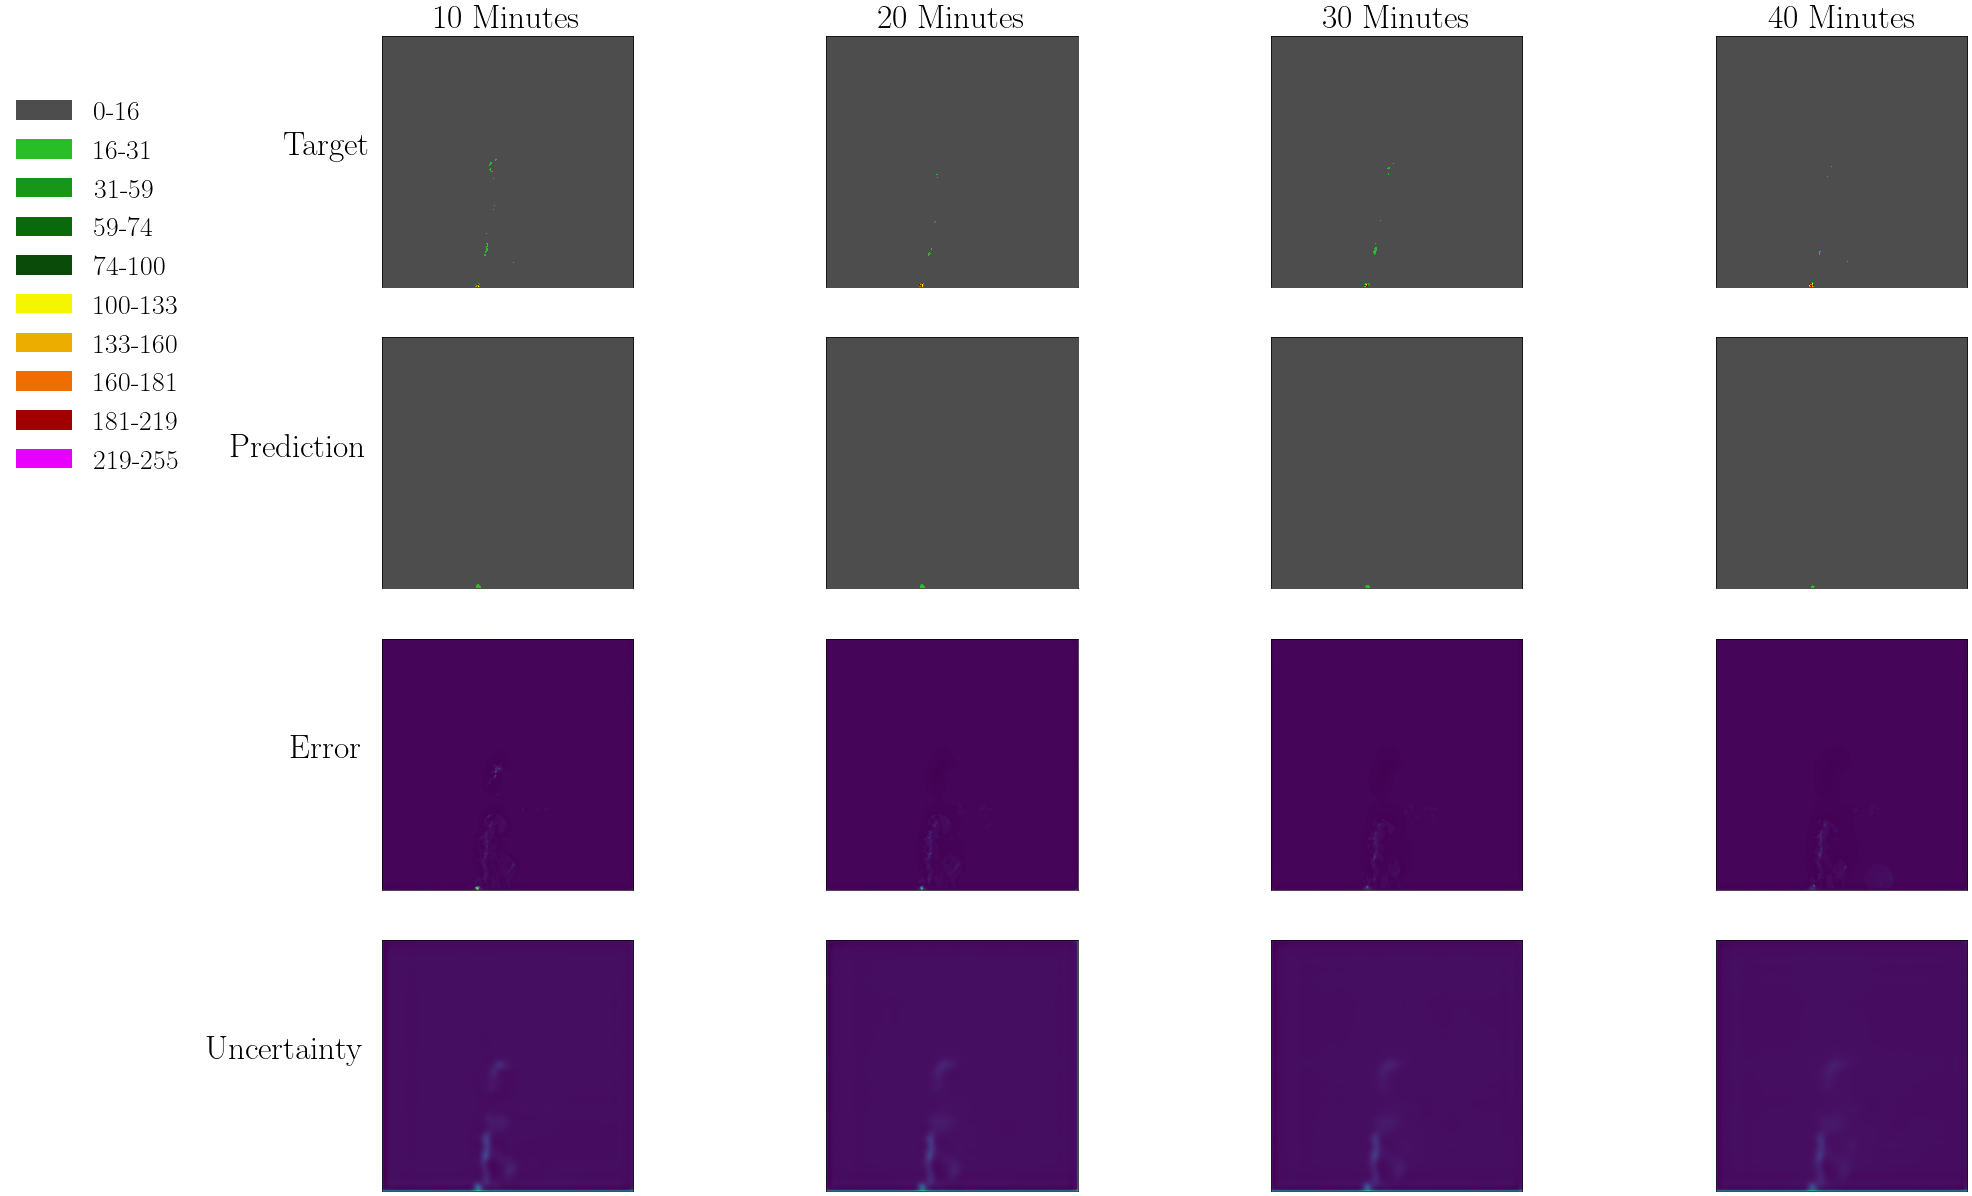

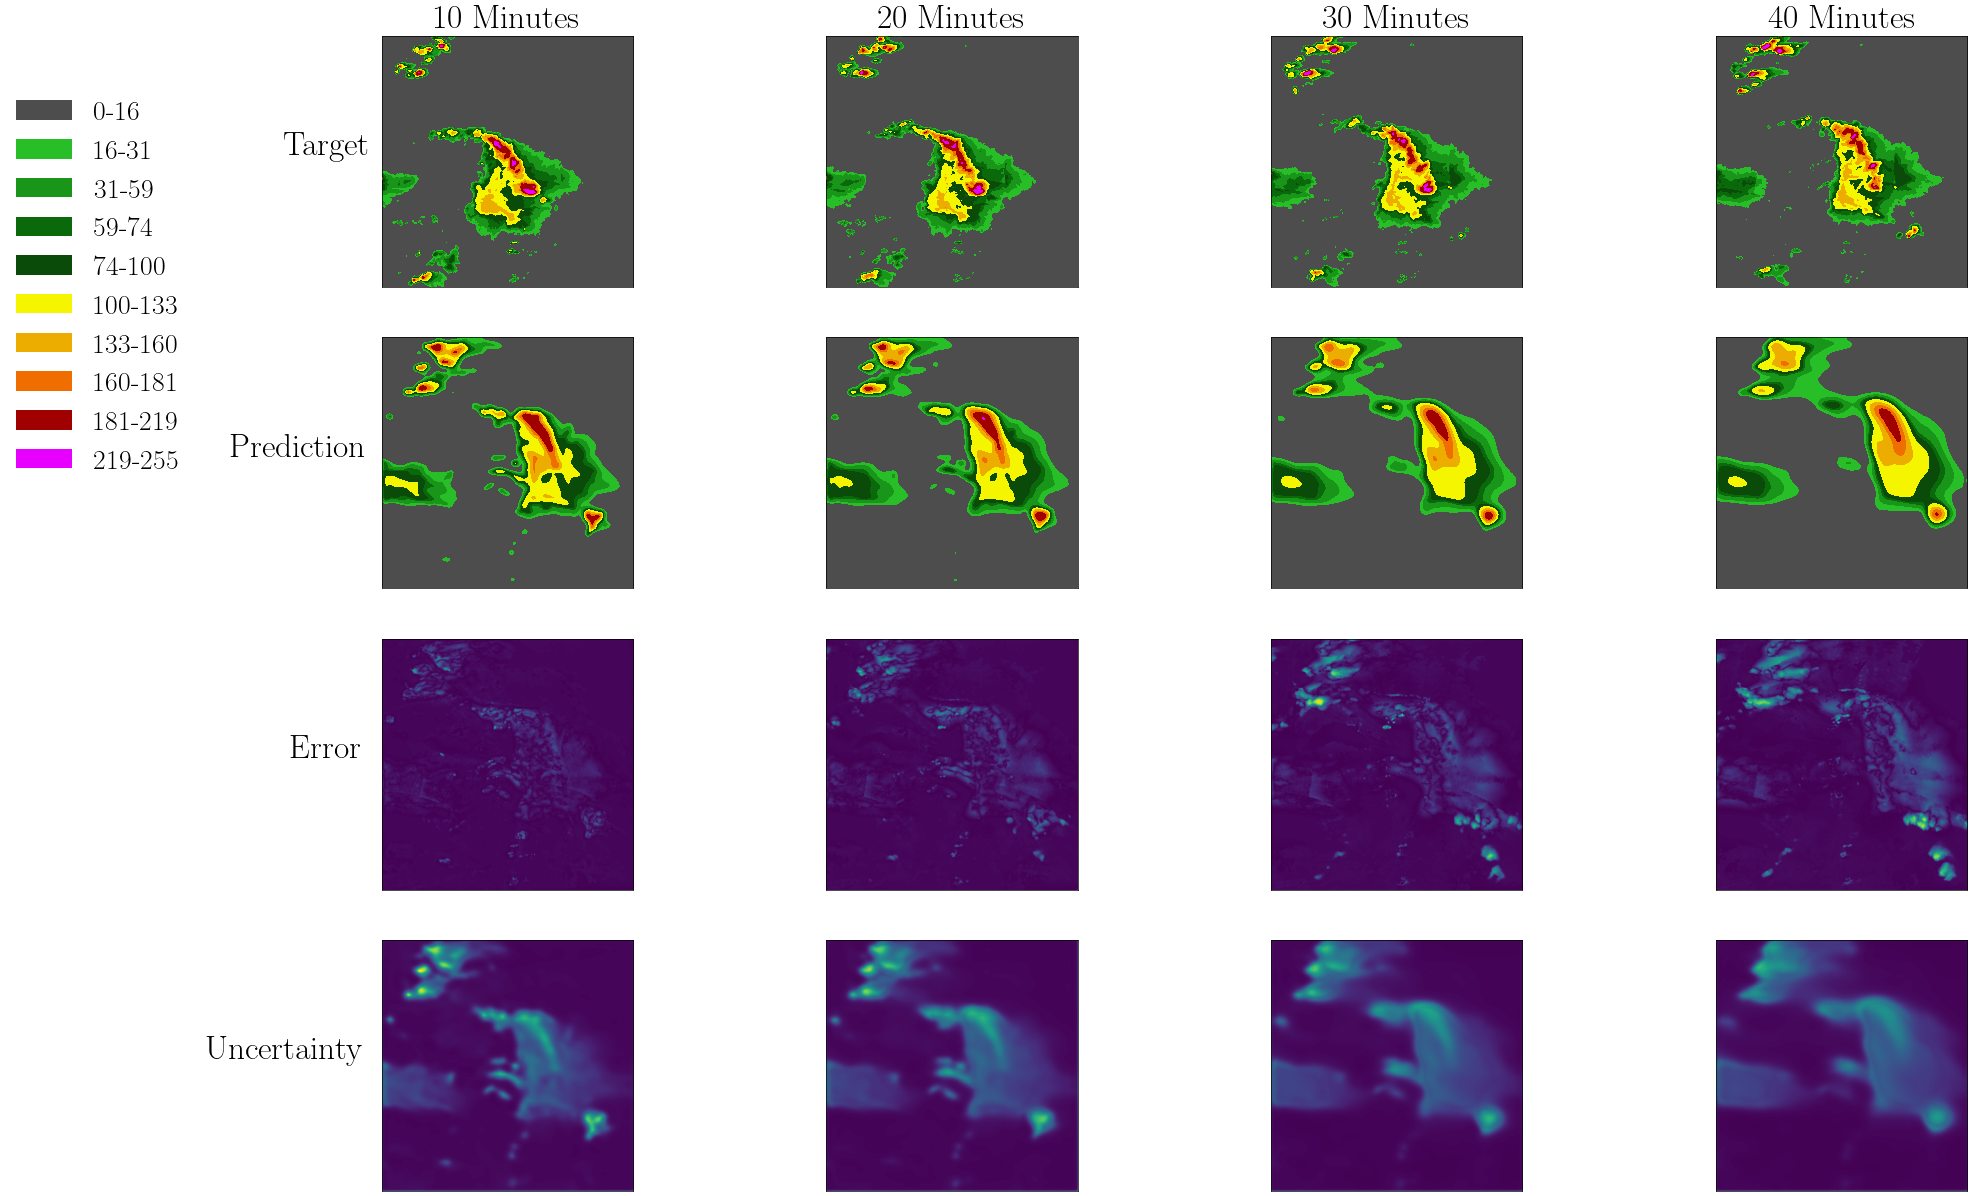

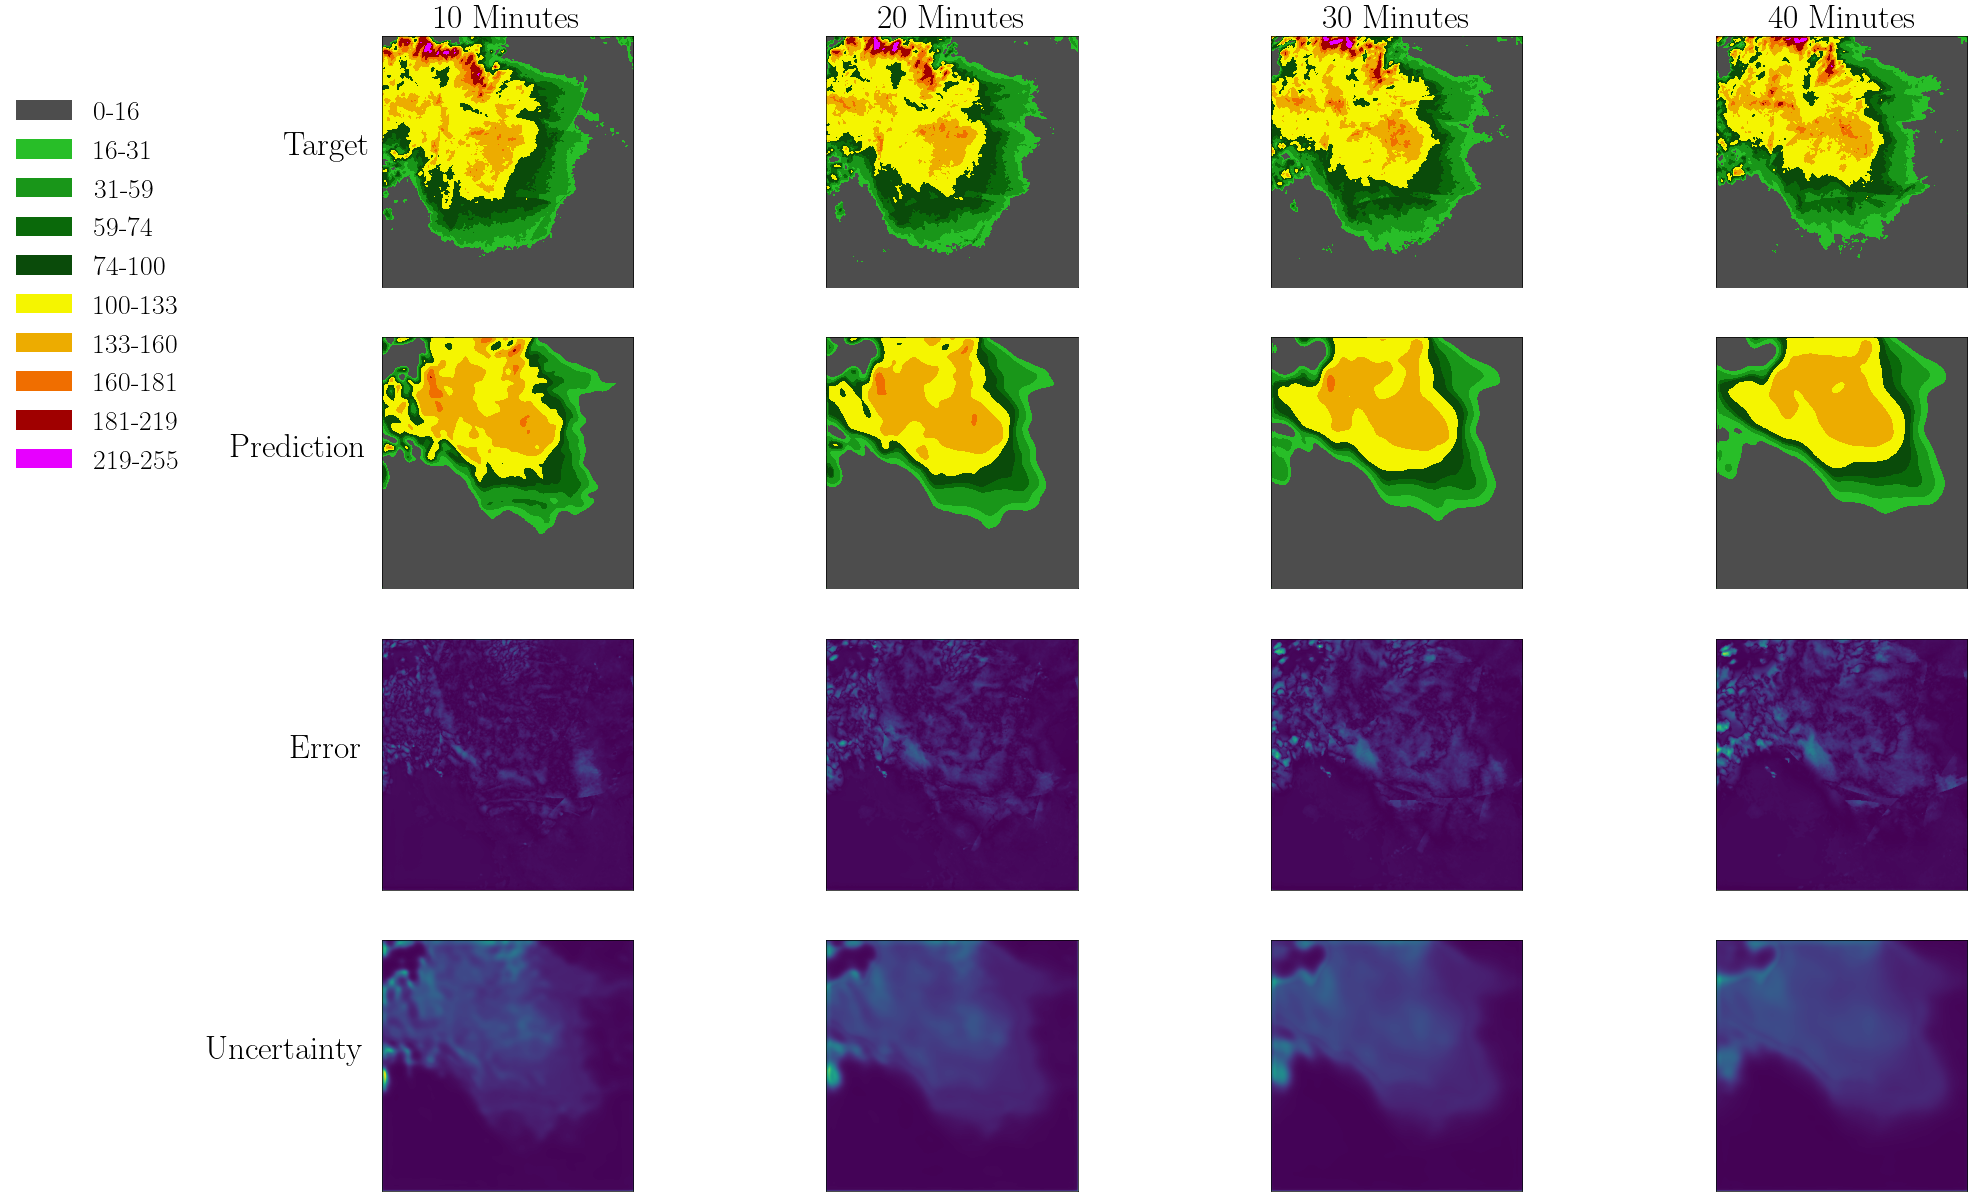

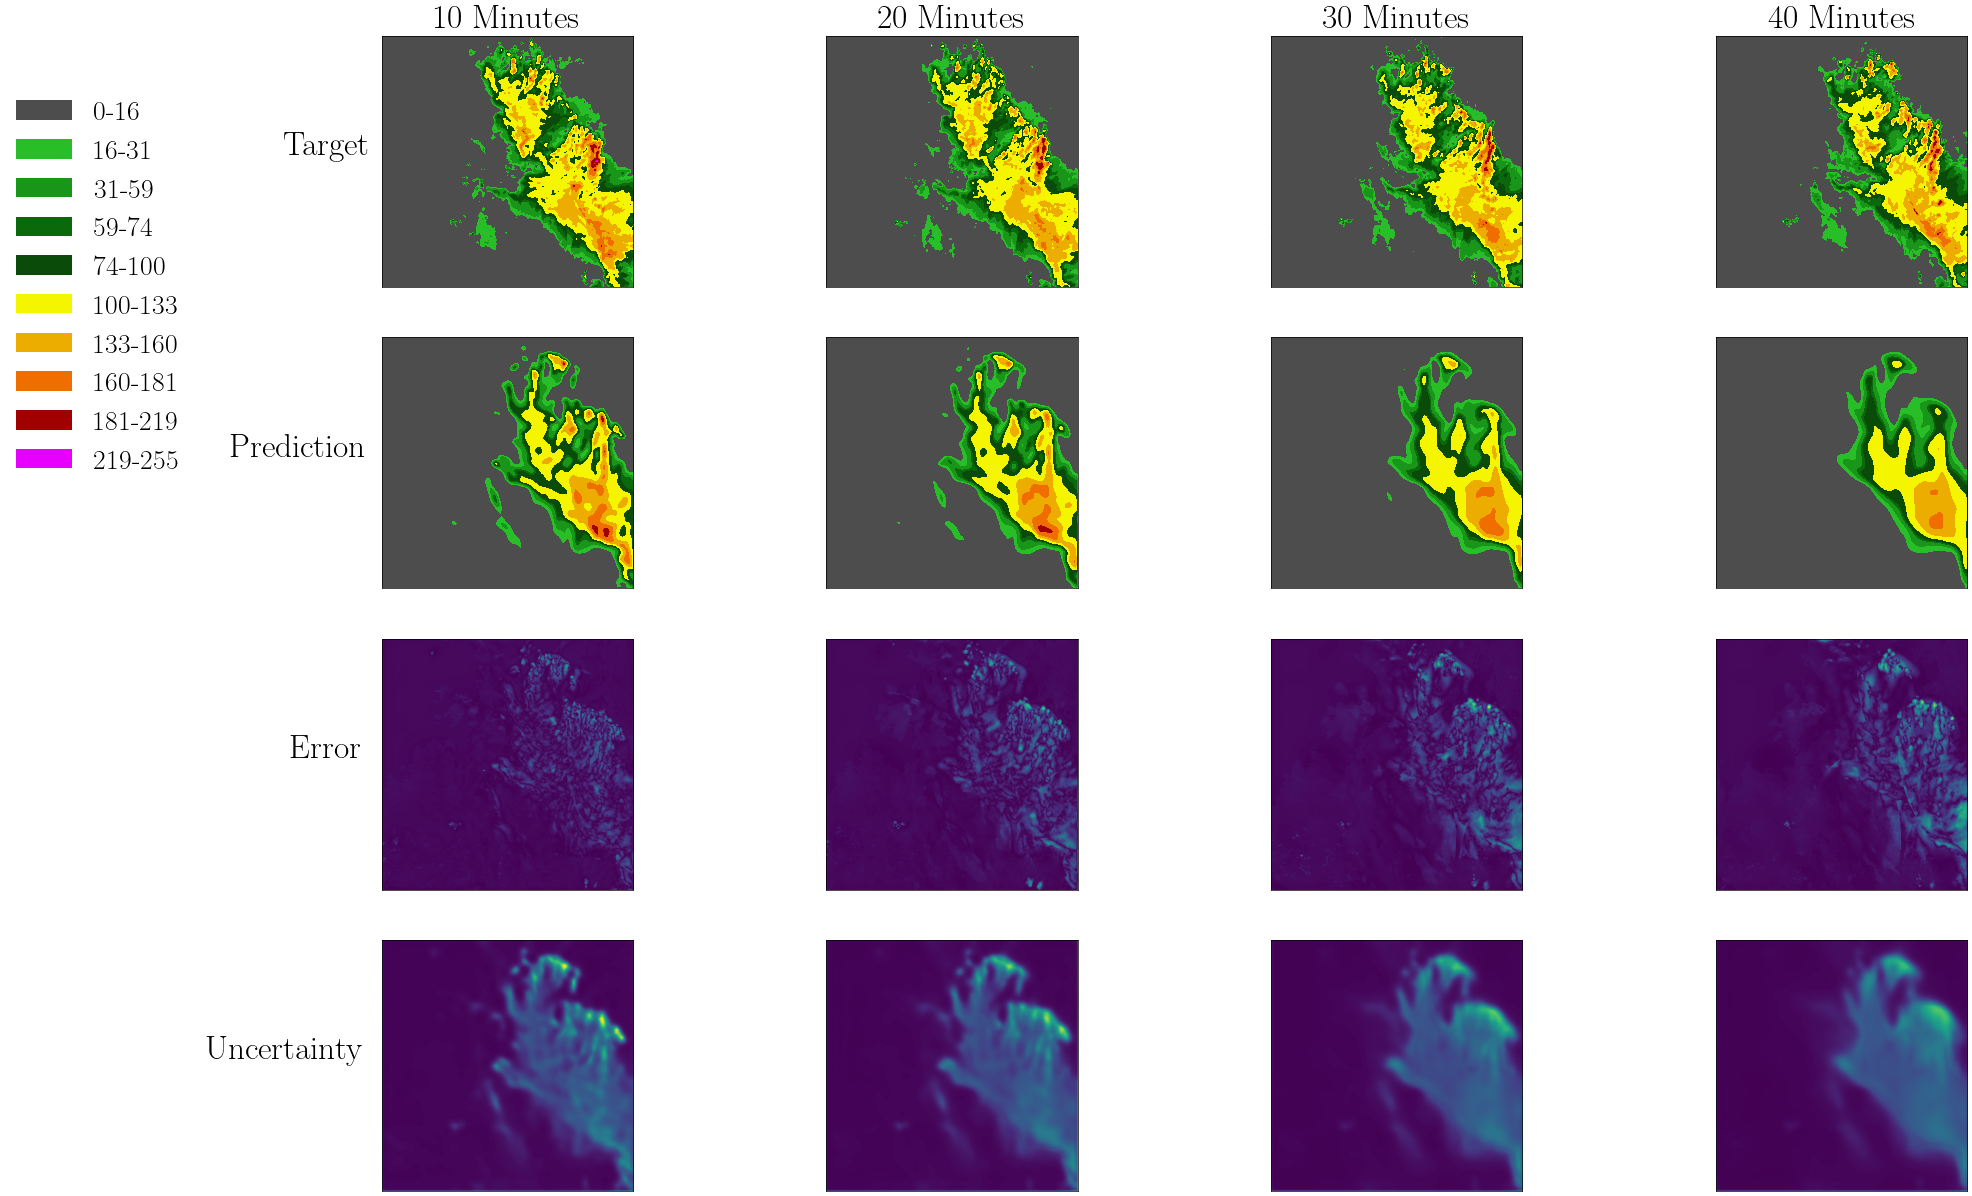

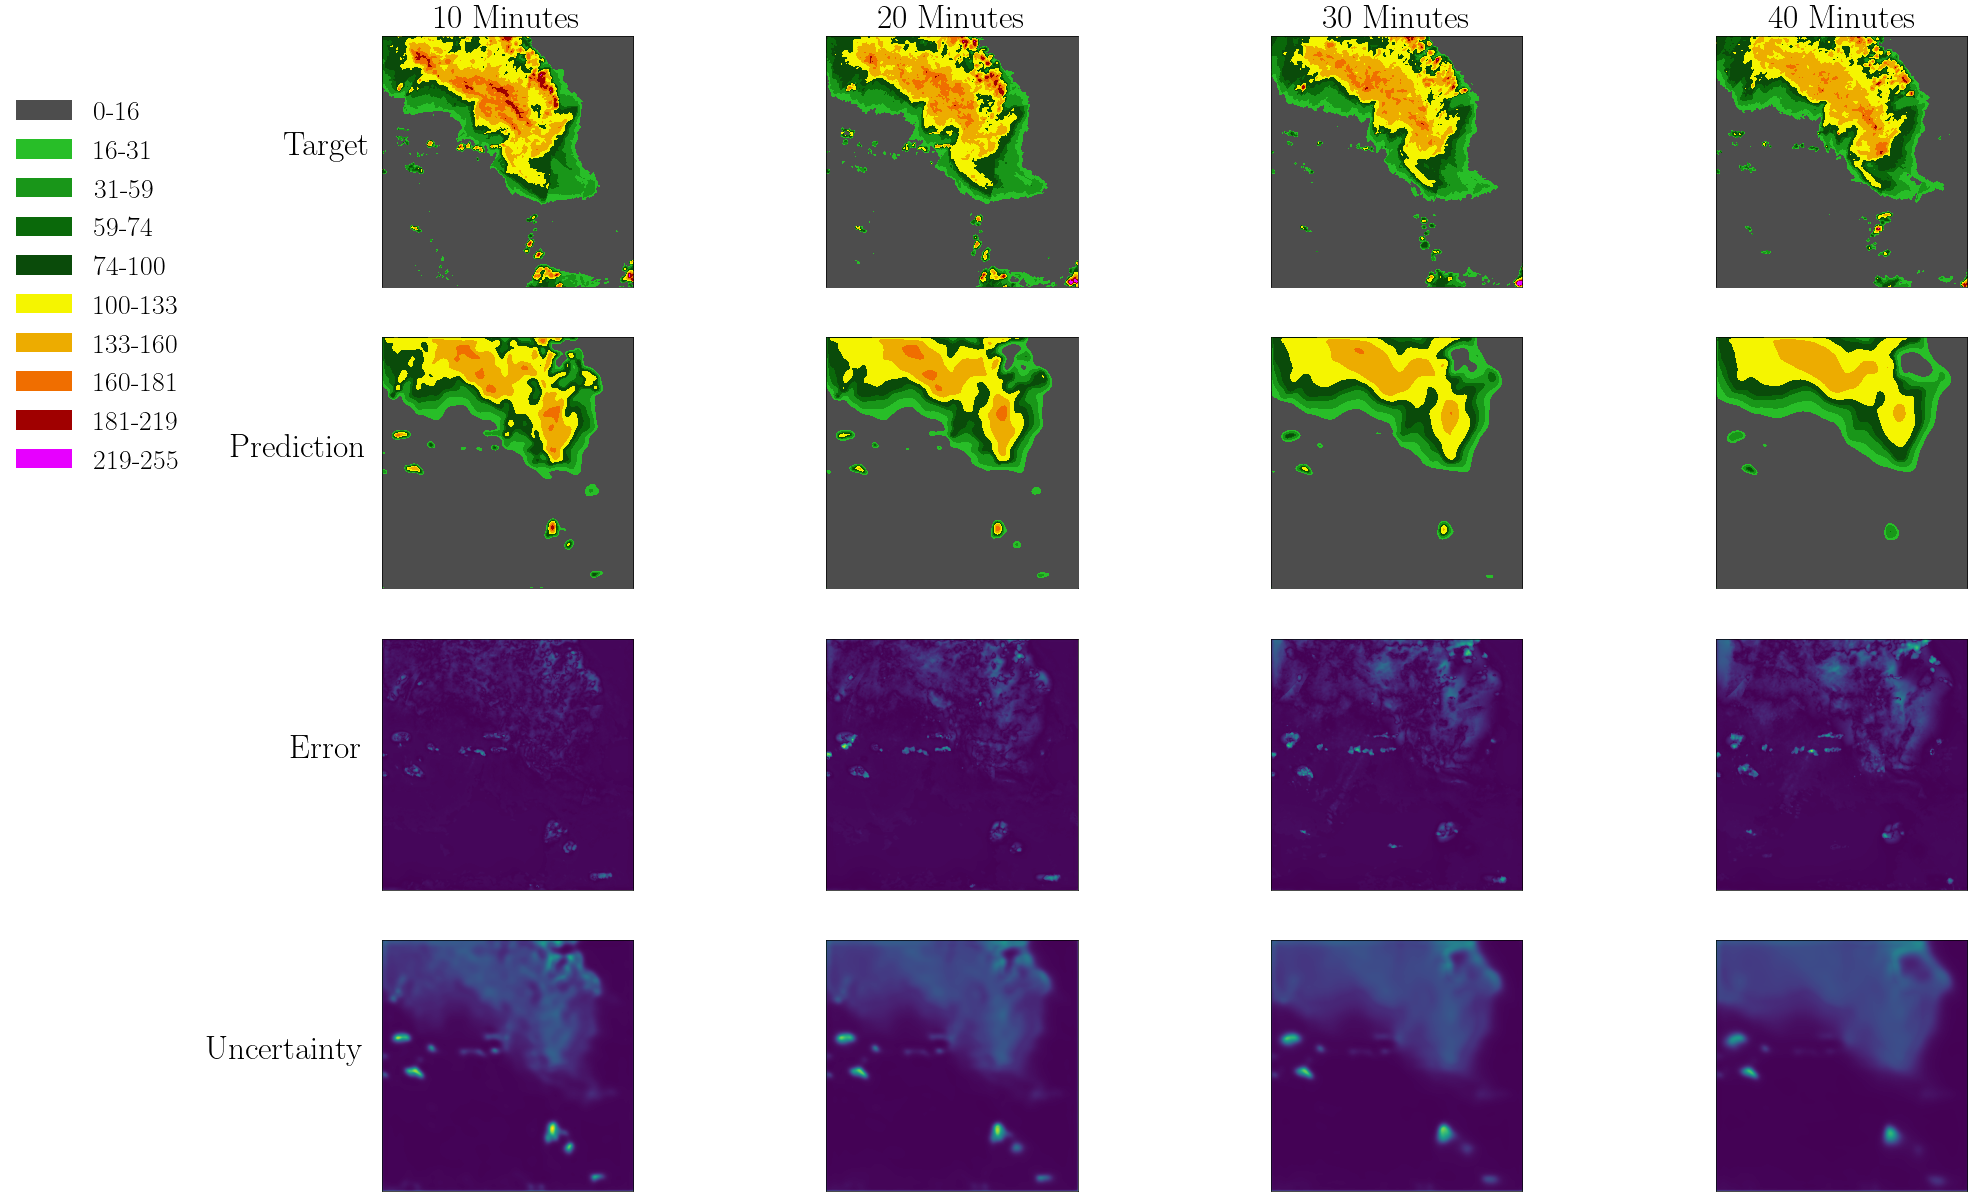

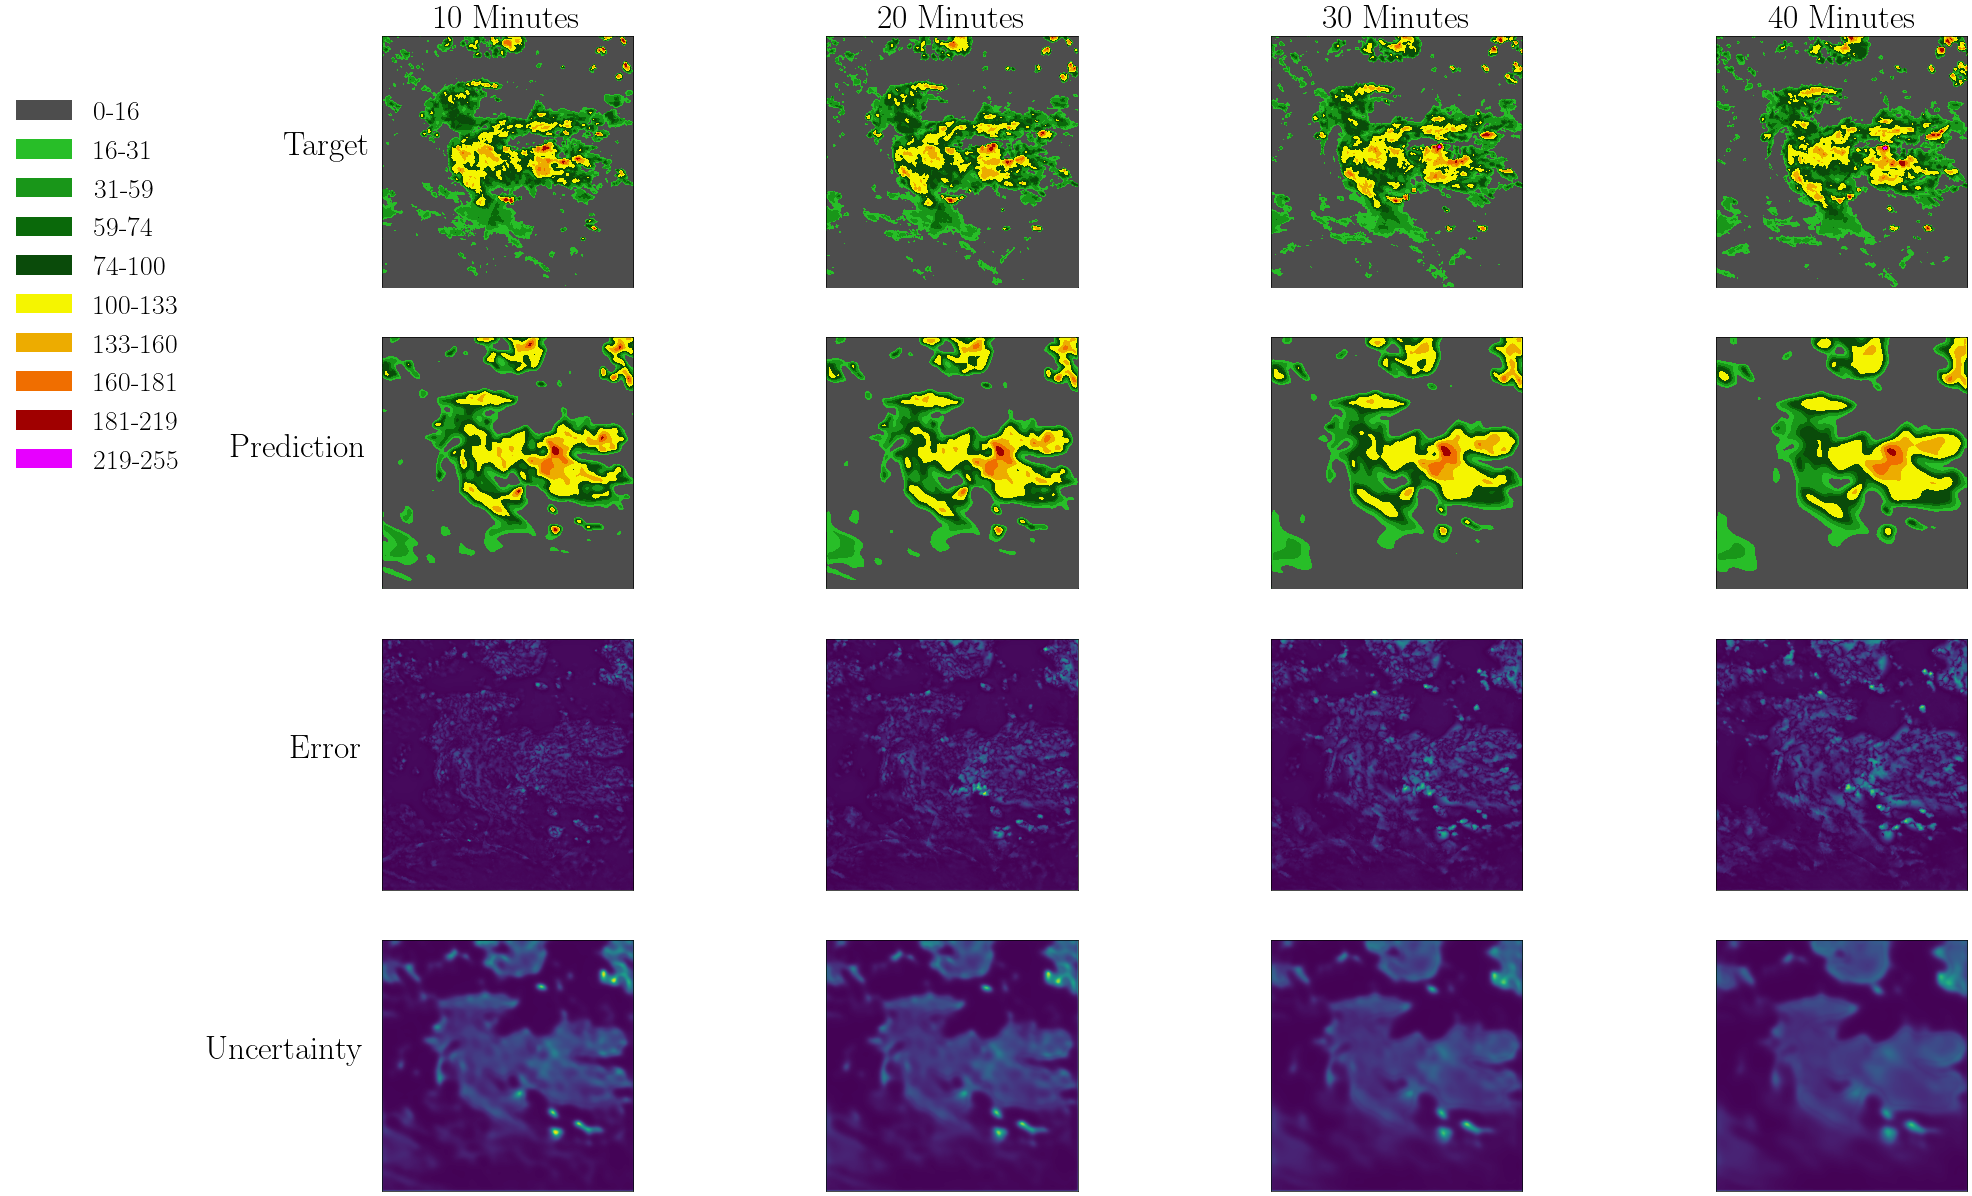

In [11]:
for batch_idx, batch in enumerate(test_loader):
    if batch_idx not in pl_module.test_example_data_idx_list:
        if batch_idx > pl_module.test_example_data_idx_list[-1]:
            break
        continue
    data_seq = batch['vil'].contiguous()
    x = data_seq[pl_module.in_slice].to(device)
    y = data_seq[pl_module.out_slice].to(device)
    micro_batch_size = x.shape[pl_module.layout.find("N")]
    data_idx = int(batch_idx * micro_batch_size)
    
    output = model(x)
    gamma, v, alpha, beta = torch.split(output, 1, -1)
    aleatoric = beta/(alpha - 1)
    epistemic = aleatoric/v
    
    generate_image(x.detach().float().cpu().numpy()* 255,
                   gamma.detach().float().cpu().numpy()* 255,
                   ((y - gamma)**2).detach().float().cpu().sqrt().numpy(),
                   epistemic.detach().float().cpu().sqrt().numpy(),
                   "figures/EDL_" + model_name + "_" + str(batch_idx) + ".pdf")